In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.notebook import tqdm

In [2]:
# !pip install dynesty  <---------------- Use if you don't have dynesty installed
import dynesty
from dynesty import plotting as dyplot

# Model Comparison
Let's start as basically as possible. We have some data $D$, and we have a set of models $\{M_0, M_1, M_2, .... M_i\}$. From the data, we wish to infer which model is 'true' (speaking loosely). There are two ways that we can go about this: the wrong way, or the right way. Let's start with the wrong way.

## The wrong way: Frequentism
In frequentism, you typically have a null model $M_0$ (usually called a null hypothesis $H_0$), and a model that you are interested in $M_1$ (or $H_1$). To use an example, let's say we have some data and wish to determine whether there is a linear trend. The null model $M_0$ is that the data are described by a constant (no trend), and $M_1$ is that the data are described by a line with slope $b$. A frequentist would fit both models, then construct a test statistic. They then ask: "If $M_0$ were true, how often would I observe a test statistic this extreme?"

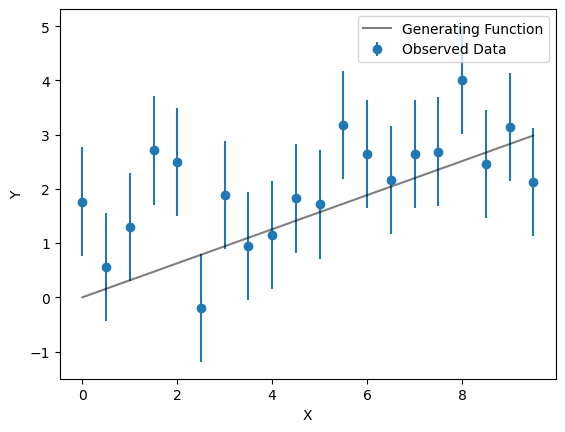

In [4]:
#################
# Generate Data #
#################
np.random.seed(0)

# Real generating model has a slight trend, with large error bars
x = np.arange(0, 10, 0.5)
b = 0.3141  # slope
sigma = 1.0  # uncertainty
noise = np.random.normal(scale=sigma, size=len(x))
y = b*x + noise

#############
# Plot Data #
#############
plt.figure()
plt.errorbar(x, y, yerr=sigma, fmt='o', label = 'Observed Data')
plt.plot(x, b*x, color = 'black', label = 'Generating Function', alpha = 0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

Best fitting params for M0:   [2.06130959]
Best fitting params for M1:   [0.19439202 1.13794752]


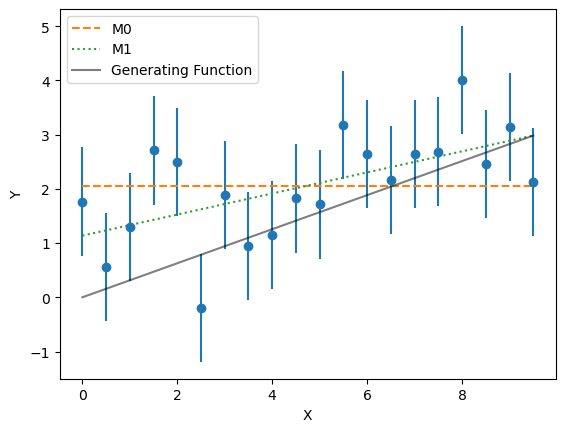

In [5]:
#################
# Define Models #
#################
def M0(x, c): # constant model
    return c*np.ones_like(x)

def M1(x, b, c): # line model
    return b*x + c

##############
# Fit Models #
##############
params_opt0, _ = curve_fit(M0, x, y, sigma=sigma*np.ones_like(y))
params_opt1, _ = curve_fit(M1, x, y, sigma=sigma*np.ones_like(y))

print('Best fitting params for M0:  ', params_opt0)
print('Best fitting params for M1:  ', params_opt1)

##############
# Plot Models #
##############
plt.figure()
plt.errorbar(x, y, yerr=sigma, fmt='o')
plt.plot(x, M0(x, *params_opt0), label='M0', ls = '--')
plt.plot(x, M1(x, *params_opt1), label='M1', ls = ':')
plt.plot(x, b*x, color = 'black', label = 'Generating Function', alpha = 0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [6]:
#################
# Compute chi^2 #
#################
chi2_M0 = np.sum(((y - M0(x, *params_opt0)) / sigma)**2)
chi2_M1 = np.sum(((y - M1(x, *params_opt1)) / sigma)**2)

print(f'M0 Chi Squared: {chi2_M0:.2f}')
print(f'M1 Chi Squared: {chi2_M1:.2f}')

M0 Chi Squared: 18.36
M1 Chi Squared: 12.07


We can calculate a p-value using the likelihood ratio test. For Gaussian errors, this simplifies to comparing $\Delta\chi^2$ against a $\chi^2$ distribution with degrees of freedom equal to the difference in number of parameters.

In [8]:
#####################
# Calculate p-value #
#####################

#  Difference in chi2 -----v               v----------- Difference in number of parameters
p_value = stats.chi2.sf(chi2_M0-chi2_M1, df=1)

print(f'p-value: {p_value:.3f}')

p-value: 0.012


But what does this p-value actually mean? p-values are often a source of confusion and are sometimes misused. What the p-value is asking here is: "If $M0$ (the constant model) were actually true, and I fit both a constant and a line, how often would the line appear to improve the fit by $\Delta\chi^2$ or more from just fitting noise?"

The answer here is about 1.2% of the time. As the p-value is below the often used (but arbitrary) value of 0.05, the frequentist would reject the null hypothesis/model, and by default, accept the alternative model. This **does not** mean that $M0$ has a 1.2% chance of being true, nor does it mean that $M1$ has a >98% chance of being true. What the p-value is measuring is:

$$ P(\text{observe data this extreme } | M0 \text{ is True}) $$ 
and not

$$ P(M0\text{ is True }|\text{ data})$$

Confusing these two is known as the *prosecutor's fallacy* or *transposing the conditional*. The frequentist framework  simply doesn't answer the question "which model is probably true?" It answers "would this data be surprising under $M0$?". Rejecting $M0$ is not the same as establishing that $M1$ is correct (a common-ish mistake), all you can infer is that something other than $M0$ is likely going on.

<div class="alert alert-info">
<b>Note:</b> The likelihood ratio test (the p-value approach above) only works for <i>nested</i> models — where one model is a special case of the other (e.g., constant is a line with slope fixed to zero). For non-nested comparisons like Gaussian vs Lorentzian, this approach fails entirely and the resultant p-value is meaningless. A different method of obtaining a p-value would be needed.
</div>

Yet often we care about **which** model is more likely - $P(M_i |D)$ - something that frequentist statistics cannot answer.


How do frequentists deal with this? Often, they will use a heuristic to fill this gap, such as Akaike Information Criterion (AIC) or the poorly named Bayesian Information Criterion (BIC). These are defined as:

$$ \text{AIC} = 2k - 2\text{ln}(\hat{L}) \;\;\; \propto 2k + \chi^2$$
$$ \text{BIC} = k\text{ln}(n) - 2\text{ln}(\hat{L}) \;\;\; \propto k\text{ln}(n) + \chi^2$$

where:
- $k$ is the number of free parameters
- $n$ is the number of data points
- $\hat{L}$ is the maximised likelihood, which for gaussian errors is proportional to the minimised chi squared (i.e. the chi squared of the fitted model)

This "allows" models to be *ranked*, but it does not tell you anything about the probability of each model. In a purely frequentist framework - in which AIC and BIC do not lie - you can only reject models, and you cannot even rank them. 

In [12]:
#####################
# Calculate AIC/BIC #
#####################

k_M0, k_M1 = 1, 2  # number of parameters
n = len(x)

# Calculate AIC
AIC_M0 = 2*k_M0 + chi2_M0
AIC_M1 = 2*k_M1 + chi2_M1

# Calculate BIC
BIC_M0 = k_M0*np.log(n) + chi2_M0
BIC_M1 = k_M1*np.log(n) + chi2_M1

print(f'AIC: M0={AIC_M0:.2f}, M1={AIC_M1:.2f} → prefer {"M0" if AIC_M0 < AIC_M1 else "M1"}')
print(f'BIC: M0={BIC_M0:.2f}, M1={BIC_M1:.2f} → prefer {"M0" if BIC_M0 < BIC_M1 else "M1"}')

AIC: M0=20.36, M1=16.07 → prefer M1
BIC: M0=21.35, M1=18.07 → prefer M1


So when we use a frequentist adjacent heuristic, we get that $M1$ is preferred, but we cannot put a number onto how much it is preferred by.

## The correct way: Bayesianism

### Bayes Rule, for parameters
Let's start by stating Bayes rule:

$$ P(\theta | D, M) = \frac{P(D|\theta, M) P(\theta | M)}{P(D|M)}$$

here:
- The **posterior** is $P(\theta | D, M)$, the probability *distribution* over the parameters $\theta$ given (conditioned on) the observed data $D$ and a model $M$
- The **likelihood** is  $P(D|\theta, M)$, the *probability* of observing the data given a set of parameters of a model
- The **prior** is  $P(\theta | M)$, our assumed probability *distribution* of the parameters for a model
- The **evidence** is $P(D|M)$, the probability of the data given the model, *marginalised* (read: integrated / averaged) over all possible parameter values.

Personally, I hate this notation, as it can get confusing. Instead we will use:

$$ P(\theta | D, M) = \frac{\mathcal{L}(\theta)\pi(\theta)}{\mathcal{Z}} $$

where:
- $\mathcal{L}(\theta)$ is the likelihood
- $\pi(\theta)$ is the prior
- $\mathcal{Z}$ is the evidence
and only use the other notation when absolutely necessary.

When obtaining the posterior of a parameter we often ignore the evidence as it is just a normalising constant, and is hard to calculate. That is to say that the best value (and the probability distribution) for a parameter depends only on the likelihood and prior, and not the evidence. 


------------------
### Bayes Rule, for models
The above Bayes rule was written out for finding the posterior for a *parameter*. But we want to find the posterior over the *models* instead. Fortunately, Bayes works on anything, so we can write out Bayes rules for models:

$$ P(M_i | D) = \frac{P(D|M_i)P(M_i)}{P(D)}$$

Again, each term is as follows:
- $P(M_i|D)$ - the probability model $M_i$ is correct, given the data (what we want when doing model comparisons). The Posterior.
- $P(D|M_i)$ - the probability of observing the data given model $M_i$. The Likelihood.
- $P(M_i)$ - our prior belief that this model is correct (often this is equal for all models,m i.e. we are agnostic to which model is correct). The Prior.
- $P(D)$ - the probability of the data (a normalising constant)

#### But!

$P(D|M_i)$ depends on the model and its **parameters** and we haven't specified any particular set of parameters. So we need to marginalise (integrate) over all possible **parameter** values, weighted by the **parameters** prior. That is to say, we need to work out:

$$ P(D|M_i) = \int P(D|\theta,M_i) P(\theta |M_i) d\theta $$

if we rewrite this using simpler notation:

$$ P(D|M_i) = \int \mathcal{L}_i(\theta) \pi_i(\theta) d\theta = \mathcal{Z}_i $$

This is the evidence for the model! The exact same $\mathcal{Z}$ that appears in the denominator of parameter estimation version of Bayes rule.

----------------------

For now, lets assume we have just two models, $M0$ and $M1$. To calculate the probability for each model, we can do a little mathematical trick and divide the posteriors for each model, which conviently means that the $P(D)$s cancel, so we don't need to work them out. We can then compare the models as such:

$$ \frac{P(M_1)|D)}{P(M_0)|D)} = \frac{P(D|M_1)}{P(D|M_0)} \cdot \frac{P(M_1)}{P(M_0)} = \frac{\mathcal{Z}_1}{\mathcal{Z}_0} \cdot \frac{P(M_1)}{P(M_0)}$$

These terms have the following names:

$$\underbrace{\frac{P(M_1|D)}{P(M_0|D)}}_{\text{Posterior odds}} = \underbrace{\frac{\mathcal{Z}_1}{\mathcal{Z}_0}}_{\text{Bayes factor } B_{10}} \cdot \underbrace{\frac{P(M_1)}{P(M_0)}}_{\text{Prior odds}}$$

- **Prior odds**: How much you favored one model before seeing data. Often set to 1 (no preference).
- **Bayes factor**: What the data tell you. This is purely the ratio of evidences.
- **Posterior odds**: Your updated belief ratio after seeing data.

If you are agnostic to the models (i.e. prior odds are 1), then the posterior odds equal the Bayes factor. **Most of the time you only need to calculate the evidence!**

If we have more than two models, the probability of model $M_i$ is:

$$ P(M_i|D) = \frac{\mathcal{Z}_i \cdot P(M_i)}{\sum_j \mathcal{Z}_j\cdot P(M_j)} $$

This gives you a number between 0 and 1, which **is** the probability of that model compared to the set of models you have. This means you can rank them. 


<div class="alert alert-info">
<b>Note:</b> In this schema, the evidence, $\mathcal{Z}$, naturally penalises complexity. Consider the evidence integral:
    $$ \mathcal{Z} = \int \mathcal{L}_i(\theta) \pi_i(\theta) d\theta $$
This is essentially the likelihood $\mathcal{L}(\theta)$ averaged over the prior $\pi(\theta)$. 

A simple model with only a few parameters has a small prior volume. If the data fall within the region that the simple model can explain, then the likelihood is relatively high over most of that small volume, so the average (the evidence) is high.

A complex model with many more parameters has a large prior volume, i.e. it can explain many possible datasets. But for any *specific* dataset, most of the volume gives poor likelihood. The complex model may be able to explain the data very well - and hence have a high likelihood, but that region is small, so the average (the evidence) is diluted.

If this reminds you of Occams razor, this is because this is the natural embodiment of the Occam principle baked into Bayes theorem.
</div>

## A simple Bayesian example

We will start with a very basic example to demonstrate how to get model likelihoods by calculating the evidence. We will numerically integrate $\mathcal{Z}$ for both the constant and linear models above. For simplicity, we will assume uniform priors. However, prior choice is **extremely** important here, a point which we will return to.

In [16]:
#############################
# Bayesian Model Comparison #
#############################

# Define prior ranges
c_range = np.linspace(-3, 3, 500)      # prior on constant (both models)
b_range = np.linspace(-1, 1, 500)      # prior on slope (M1 only)  - Note this is NOT the most uninformative prior

# d theta  (i.e. width of the rectangles of the evidence integral)
dc = c_range[1] - c_range[0]
db = b_range[1] - b_range[0]

prior_c = 1.0 / (c_range[-1] - c_range[0])

# Evidence for M0
# Integrate Z = L(c) * pi(c) over c
# Numerical integral is just summation
Z_M0 = 0
L_M0 = []

t0 = time.time() # keep track of how long this takes
for c in c_range:
    # calculate likelihood for a set of parameters
    chi2 = np.sum(((y-M0(x, c)) / sigma)**2)
    L = np.exp(-0.5*chi2)
    L_M0.append(L)
    # add likelihood times prior width unit
    Z_M0 += L * prior_c * dc

t_M0 = time.time() - t0

We can plot the prior, the likelihood, and the evidence. In this case, the evidence looks like the likelihood because of the uniform prior 

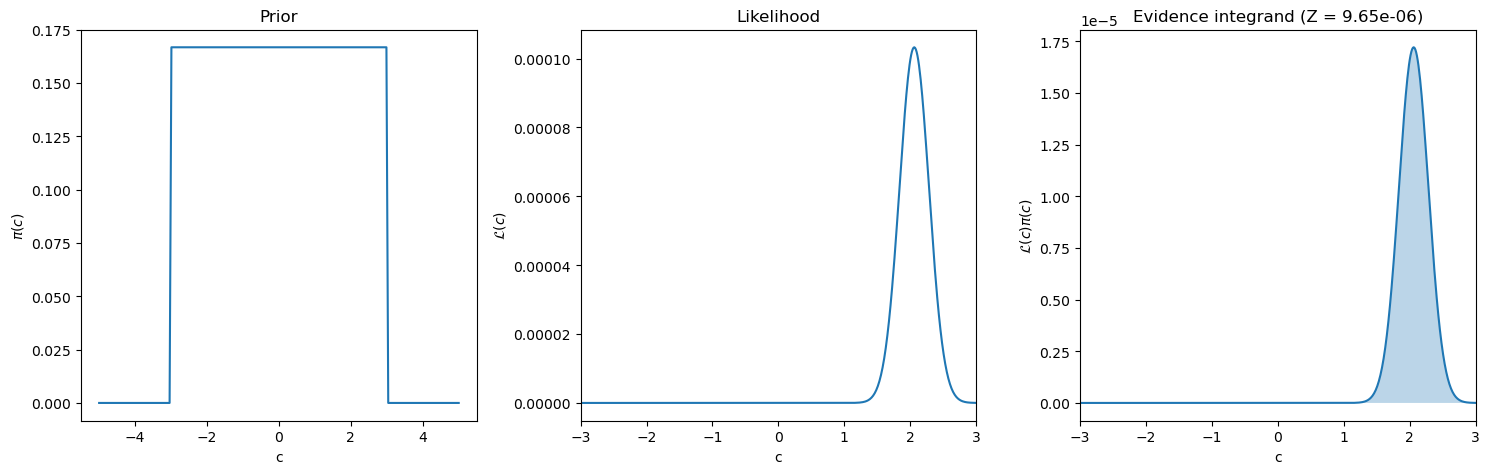

In [18]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
c_plot = np.linspace(-5, 5, 200)
prior_height = 1 / (c_range[-1] - c_range[0])
prior = np.where((c_plot >= -3) & (c_plot <= 3), prior_height, 0)
plt.plot(c_plot, prior)
plt.xlabel('c')
plt.ylabel(r'$\pi(c)$')
plt.title('Prior')

plt.subplot(1,3,2)
plt.plot(c_range, L_M0)
plt.xlabel('c')
plt.ylabel(r'$\mathcal{L}(c)$')
plt.title('Likelihood')
plt.xlim(-3,3)

plt.subplot(1,3,3)
integrand = np.array(L_M0) * prior_height
plt.fill_between(c_range, integrand, alpha=0.3)
plt.plot(c_range, integrand)
plt.xlabel('c')
plt.ylabel(r'$\mathcal{L}(c)\pi(c)$')
plt.title(f'Evidence integrand (Z = {Z_M0:.2e})')
plt.xlim(-3,3)

plt.tight_layout()
plt.show()

Let's find the evidence for $M1$:

In [20]:

prior_b = 1.0 / (b_range[-1] - b_range[0])

# Evidence for M1
# Integrate Z = L(c) * pi(c) over c and b
# Numerical integral is just summation
Z_M1 = 0

t0 = time.time()
for b in b_range:
    for c in c_range:
        chi2 = np.sum(((y - M1(x, b, c)) / sigma)**2)
        L = np.exp(-0.5 * chi2)
        Z_M1 += L * prior_b * prior_c * db * dc
t_M1 = time.time() - t0

print(f'Evidence M0: {Z_M0:.2e}')
print(f'Evidence M1: {Z_M1:.2e}')

# Bayes factor
B_10 = Z_M1 / Z_M0
print(f'Bayes factor B_10: {B_10:.2f}  <------------- IMPORTANT')

Evidence M0: 9.65e-06
Evidence M1: 2.17e-05
Bayes factor B_10: 2.25  <------------- IMPORTANT


We can translate this to model probabilties like this:

In [22]:
#######################
# Model Probabilities #
#######################

P_M0 = Z_M0 / (Z_M0 + Z_M1)
P_M1 = Z_M1 / (Z_M0 + Z_M1)
print(f'P(M0|D) = {P_M0:.3f}')
print(f'P(M1|D) = {P_M1:.3f}')

P(M0|D) = 0.308
P(M1|D) = 0.692


In this case, we can say that the $M1$ is about 2.3x as likely as $M0$.

Note that this is a very different number to the p-value calculated above. While these numbers are not comparable, this is a common misinterpretation of p-values.


So we have a Bayes factor of 2.25 - how should we interpret this? Well according to the Jeffreys' scale (below), this result is not worth more than a bare mention.

| Bayes Factor | Strength of evidence |
|-----------|----------|
| 1 to 3.2  | Not worth more than a bare mention  |
| 3.2 to 10 | Substantial  |
| 10 to 100 | Strong  |
| > 100     | Decisive  |

Note that this table is just a rule of thumb, not anything more. 

Take a moment to appreciate that the frequentist view only allowed us to (confidently) reject the null hypothesis and, using heuristics such as AIC/BIC, allow us to say that M1 is preferred. It did not allow us to say how much more likely a certain model was, or if the differences between models were worth mentioning.

<div class="alert alert-info">
<b>Note:</b> The Jeffreys' scale is named after Sir Harold Jeffreys, who played an important role in the revival of the "objective Bayesian view of probability". He was born in 1891 and died in 1989. 


Given that Reverend Thomas Bayes was born at the very beginning of the 16th Century, one may wonder why it took so long for Bayesian statistics to become commonly adopted. The next section can help explain this.
</div>

### The downside to Bayesian model comparison

When calculating the evidence for $M0$, we had to numerically integrate over the values of $c$. We timed this and determined that this took:

In [25]:
print(f'M0 evidence calculation time: {t_M0:.2e} seconds')

M0 evidence calculation time: 6.01e-03 seconds


For $M1$, we had to integrate over $c$ and $b$, which we also timed:

In [27]:
print(f'M1 evidence calculation time: {t_M1:.3f} seconds')
print(f'One extra parameter took {t_M1/t_M0:.1f}x longer')

M1 evidence calculation time: 2.529 seconds
One extra parameter took 421.2x longer


This is a very large difference, especially when we consider that this was a simple model with Gaussian likelihood and only 20 datapoints. As more parameters are added, the number of samples required grows exponentially. While many optimisations could be done, e.g. vectorisation, clearly numerically integrating the $\mathcal{Z}$ integral like this (i.e. a grid search) is not feasible. 

The problem arises from having to numerically solve a highly multi-dimensional integral. Wouldn't it be nice if we could instead just numerically solve a one-dimensional integral instead.....

## Nested Sampling

Nested sampling was invented by John Skilling - see this [surprisingly approachable original paper](https://www.inference.org.uk/bayesys/nest.pdf) if you want more detail.

We want to solve:

$$ \mathcal{Z} = \int \mathcal{L}(\theta)\pi(\theta) \, d\theta $$

Nested sampling allows us to instead solve the following integral, which is essentially just a change of variables:

$$ \mathcal{Z} = \int_0^1 \mathcal{L}(X) \, dX $$

where $X$ is the *enclosed prior volume* - the fraction of the prior where likelihood exceeds some threshold - and $\mathcal{L}(X)$ is the likelihood value at that threshold.

The idea is to sort the parameter space by likelihood. Instead of integrating over parameters directly, we integrate over "how much prior volume has likelihood above a given value." This turns a complicated multi-dimensional integral into a one-dimensional integral.  However, **actually** doing this change of variables analytically is hard - at least as hard as the original integral. The nested sampling algorithm is used to instead estimate the $X$ values statistically.

<div class="alert alert-info">
<b>Derivation:</b> Define $X(\lambda)$ as the prior volume with likelihood exceeding $\lambda$:

$$ X(\lambda) = \int_{\mathcal{L}(\theta) > \lambda} \pi(\theta) \, d\theta $$

As $\lambda$ increases, $X$ decreases from 1 (all prior volume, at $\lambda = 0$) to 0 (just the likelihood peak). Since this relationship is monotonic, you can (in theory) invert it to get $\mathcal{L}(X)$.

The original integral sums likelihood × prior volume over parameter space. We can reorganise by likelihood contours: the prior volume between $X$ and $X + dX$ is $dX$, and the likelihood there is $\mathcal{L}(X)$. So:

$$ \mathcal{Z} = \int_0^1 \mathcal{L}(X) \, dX $$

This is the same integral, just expressed differently.
</div>

The nested sampling algorithm is:
  1) Draw K 'live points' from the prior
  2) Calculate the likelihood for each live point
  3) Find the point with the lowest likelihood ($\mathcal{L}_{\text{min}}$) and remove it. This is the first 'dead point'.
  4) Replace this point by drawing a new point from the prior, with the constraint that $\mathcal{L}_{\text{new}} > \mathcal{L}_{\text{old}}$
  5) Repeat steps 3 and 4, recording each dead point and its likelihood
  6) Stop when the remaining volume is neglibable



Let's demonstrate this by computing the evidence for $M_1$ (the line model) using nested sampling, and compare to our grid integration result.

In [30]:
# Define prior ranges (same as our grid integration)
c_min, c_max = -3, 3
b_min, b_max = -1, 1

# Create grid for visualization
b_grid = np.linspace(b_min, b_max, 500)
c_grid = np.linspace(c_min, c_max, 500)
B, C = np.meshgrid(b_grid, c_grid)

# Calculate likelihood on grid
L_surface = np.zeros_like(B)
for i in range(len(c_grid)):
    for j in range(len(b_grid)):
        model = B[i,j] * x + C[i,j]
        chi2 = np.sum(((y - model) / sigma)**2)
        L_surface[i,j] = np.exp(-0.5 * chi2)

# Normalize for visualization
L_surface_norm = L_surface / L_surface.max()

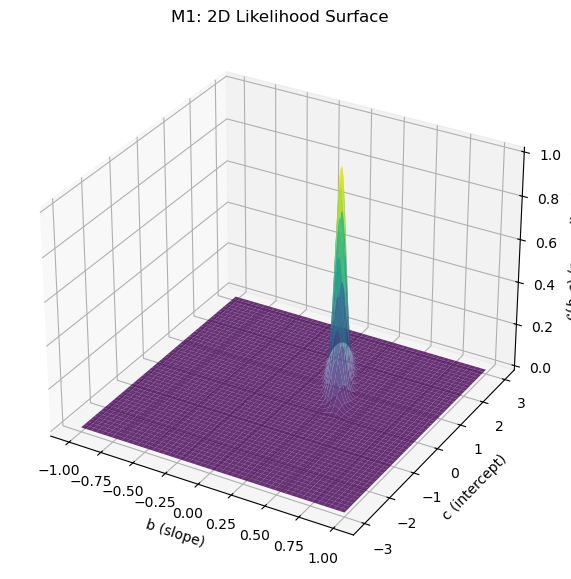

In [31]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(B, C, L_surface_norm, cmap='viridis', alpha=0.8)
ax.set_xlabel('b (slope)')
ax.set_ylabel('c (intercept)')
ax.set_zlabel(r'$\mathcal{L}(b,c)$ (normalized)')
ax.set_title('M1: 2D Likelihood Surface')
plt.show()

Steps 1 and 2: we will randomly draw $K$ "live points" from the prior $\pi(b, c)$ and measure their likelihood.

In [33]:
np.random.seed(10)
K = 10 # number of "live points" (very low for visualisation purposes, use more irl)

# Initialize
live_points = np.column_stack([
    np.random.uniform(b_min, b_max, size=K),    # as our priors are uniform, we can just use  np.random.uniform
    np.random.uniform(c_min, c_max, size=K)     # if our priors were complex, we would have to SAMPLE from them
])

# Helper function
def log_likelihood_M1(b, c):
    """Log-likelihood for line model"""
    model = b * x + c
    return -0.5 * np.sum(((y - model) / sigma)**2)

log_L_live = np.array([log_likelihood_M1(p[0], p[1]) for p in live_points])

# Storage
dead_points = []
dead_log_L = []

Step 3: Find the lowest likelihood point

In [35]:
# Find lowest likelihood point
idx_min = np.argmin(log_L_live)
log_L_min = log_L_live[idx_min]
dead_point = live_points[idx_min].copy()

Step 3 continued: Store dead point, and remove it.

Step 4: Draw a new point

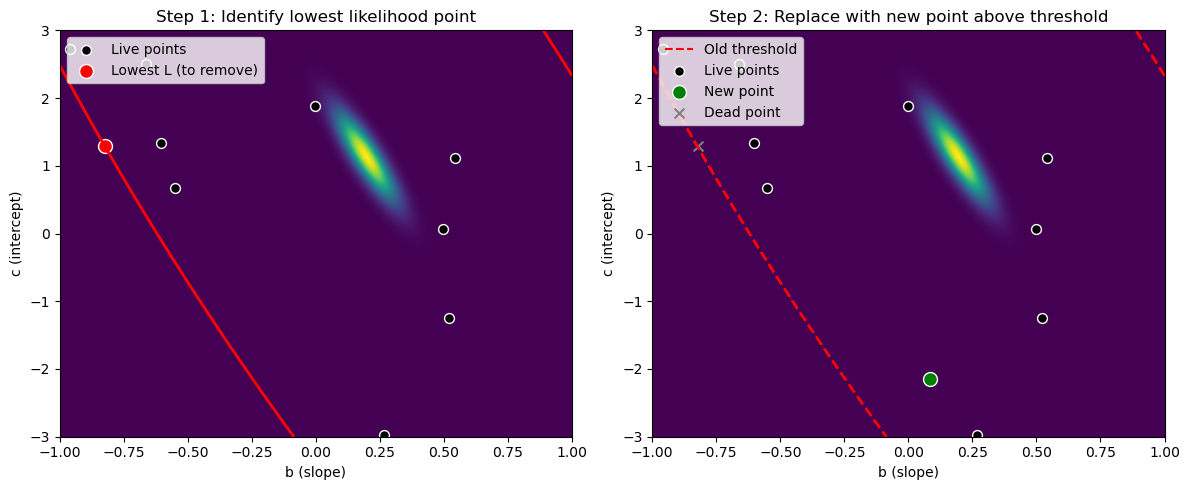

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel 1: Before: highlight point to remove
ax1 = axes[0]
ax1.imshow(L_surface_norm, extent=[b_min, b_max, c_min, c_max], origin='lower', cmap='viridis', aspect='auto')
ax1.scatter(live_points[:,0], live_points[:,1], color='black', s=50, edgecolor='white', label='Live points')
ax1.scatter(dead_point[0], dead_point[1], color='red', s=100, edgecolor='white', label='Lowest L (to remove)')
ax1.contour(B, C, L_surface_norm, levels=[np.exp(log_L_min)/L_surface.max()], colors='red', linewidths=2)
ax1.set_xlabel('b (slope)')
ax1.set_ylabel('c (intercept)')
ax1.set_title('Step 1: Identify lowest likelihood point')
ax1.legend(loc = 'upper left')

####################
# Store dead point #
####################

dead_points.append(dead_point)
dead_log_L.append(log_L_min)

##########################################
# Replace with new point above threshold #
##########################################

while True:  # while as we need to keep sampling until likelihood criteria is met
    new_b = np.random.uniform(b_min, b_max)
    new_c = np.random.uniform(c_min, c_max)
    new_log_L = log_likelihood_M1(new_b, new_c)
    if new_log_L > log_L_min:
        live_points[idx_min] = [new_b, new_c]
        log_L_live[idx_min] = new_log_L
        break

# Panel 2: After: show new point
ax2 = axes[1]
ax2.imshow(L_surface_norm, extent=[b_min, b_max, c_min, c_max], origin='lower', cmap='viridis', aspect='auto')
ax2.contour(B, C, L_surface_norm, levels=[np.exp(log_L_min)/L_surface.max()], colors='red', linewidths=2, linestyles='--')
ax2.plot([], [], color='red', linestyle='--', label='Old threshold')
ax2.scatter(live_points[:,0], live_points[:,1], color='black', s=50, edgecolor='white', label='Live points')
ax2.scatter(new_b, new_c, color='green', s=100, edgecolor='white', label='New point')
ax2.scatter(dead_point[0], dead_point[1], color='gray', s=50, marker='x', label='Dead point')
ax2.set_xlabel('b (slope)')
ax2.set_ylabel('c (intercept)')
ax2.set_title('Step 2: Replace with new point above threshold')
ax2.legend(loc = 'upper left')

plt.tight_layout()
plt.show()

---------------
#### Before continuing, we should look at how the prior volume, $X_i$, is actually estimated -- and thus how we estimate the evidence volume

Since live points are sampled from the prior, they are uniform in **prior volume** $X$ by construction. On average, the lowest likelihood sits at the $1/K$-th quantile of the volume. Removing the it and everything below its likelihood contour chops off (on average) $1/(K+1)$ of the volume. Below is a visualisation of this, with K = 4:

```
K = 4 points on X in [0,1]:

0                                                             1
|-------------------------------------------------------------|
      •           •              •         •                   
   ↑      ↑            ↑              ↑          ↑
  gap    gap          gap            gap        gap
   1      2            3              4          5

K points create K+1 gaps. The expected value for each gap has size 1/(K+1).
```

This means that the remaining volume is:

$$ X_1 = 1 - \frac{1}{K+1} = \frac{K}{K+1}$$

This means that on average, each iteration shrinks the volume by a factor of $K/(K+1)$, and hence the remaining volume is:
$$ X_i \approx (\frac{K}{K+1})^i $$

We can then approximate the integral as such:

$$ \mathcal{Z} = \int_0^1 \mathcal{L}(X) \, dX  \approx \sum_i \mathcal{L}_i \, \Delta X_i$$

Remember that as we perform the nested sampling algorithm, we are saving $\mathcal{L}_i$, so this summation is able to be calculated.

Also note that each dead point is given an importance weight which is:

$$ w_i \propto \mathcal{L}_i \Delta X_i $$

<div class="alert alert-info">
<b>Note:</b> In general more live points are better, as more points means finer $\Delta X_i$ steps making the above approximation more accurate. Additionally, more points reduces the chance that the likelihood is sampled better and has less chance of skipping important regions. In general, the evidence uncertainty scales as $1/\sqrt{K}$


</div>


--------------

Step 5: Repeat steps 3 and 4. 

Here we will do 400 iterations. We will do so with more live points. Note that the actual implementation isn't too important, as we will by using `dynesty` for this soon.

In [39]:
np.random.seed(42)
K = 25  # Number of live points
iterations_to_show = [1, 50, 100, 200, 300, 400]

###################################################
# INITIALISATION: Draw K points from the prior    #
###################################################
live_points = np.column_stack([
    np.random.uniform(b_min, b_max, size=K),
    np.random.uniform(c_min, c_max, size=K)
])
log_L_live = np.array([log_likelihood_M1(p[0], p[1]) for p in live_points])

dead_points = []
dead_log_L = []
log_X = 0       # log(prior volume), starts at log(1) = 0
log_Z = -np.inf # log(evidence), starts at log(0) = -inf
snapshots = {}

#############
# MAIN LOOP #
#############
for i in tqdm(range(400)):
    if i + 1 in iterations_to_show:
        snapshots[i + 1] = live_points.copy()
    
    # Step 1: Find and remove lowest likelihood point
    idx_min = np.argmin(log_L_live)
    log_L_min = log_L_live[idx_min]
    dead_points.append(live_points[idx_min].copy())
    dead_log_L.append(log_L_min)
    
    # Step 2: Update prior volume estimate
    log_X_new = log_X - 1/K
    log_dX = log_X + np.log(1 - np.exp(-1/K))
    
    # Step 3: Accumulate evidence
    log_Z = np.logaddexp(log_Z, log_L_min + log_dX)
    log_X = log_X_new
    
    # Step 4: Check termination
    log_remaining = np.max(log_L_live) + log_X
    if log_remaining - log_Z < np.log(1e-6):
        break
    
    # Step 5: Replace dead point with new sample from constrained prior
    n_tries = 0
    while True:
        new_b = np.random.uniform(b_min, b_max)
        new_c = np.random.uniform(c_min, c_max)
        new_log_L = log_likelihood_M1(new_b, new_c)
        n_tries += 1
        if new_log_L > log_L_min:
            live_points[idx_min] = [new_b, new_c]
            log_L_live[idx_min] = new_log_L
            break
        if n_tries > 1000:
            # If the code enters here (it will), the evidence estimated will be innaccurate 
            # Dynesty has a better fix for this
            # This is just to speed up the example
            break
            
###########################################################
# FINAL STEP: Add contribution from remaining live points #
###########################################################
log_remaining_vol = log_X - np.log(K)
for log_L in log_L_live:
    log_Z = np.logaddexp(log_Z, log_L + log_remaining_vol)

dead_points = np.array(dead_points)
dead_log_L = np.array(dead_log_L)

print(f'Nested sampling Z_M1 = {np.exp(log_Z):.6e}')

  0%|          | 0/400 [00:00<?, ?it/s]

Nested sampling Z_M1 = 2.289904e-05


Below is some plotting code, don't worry about the details. 

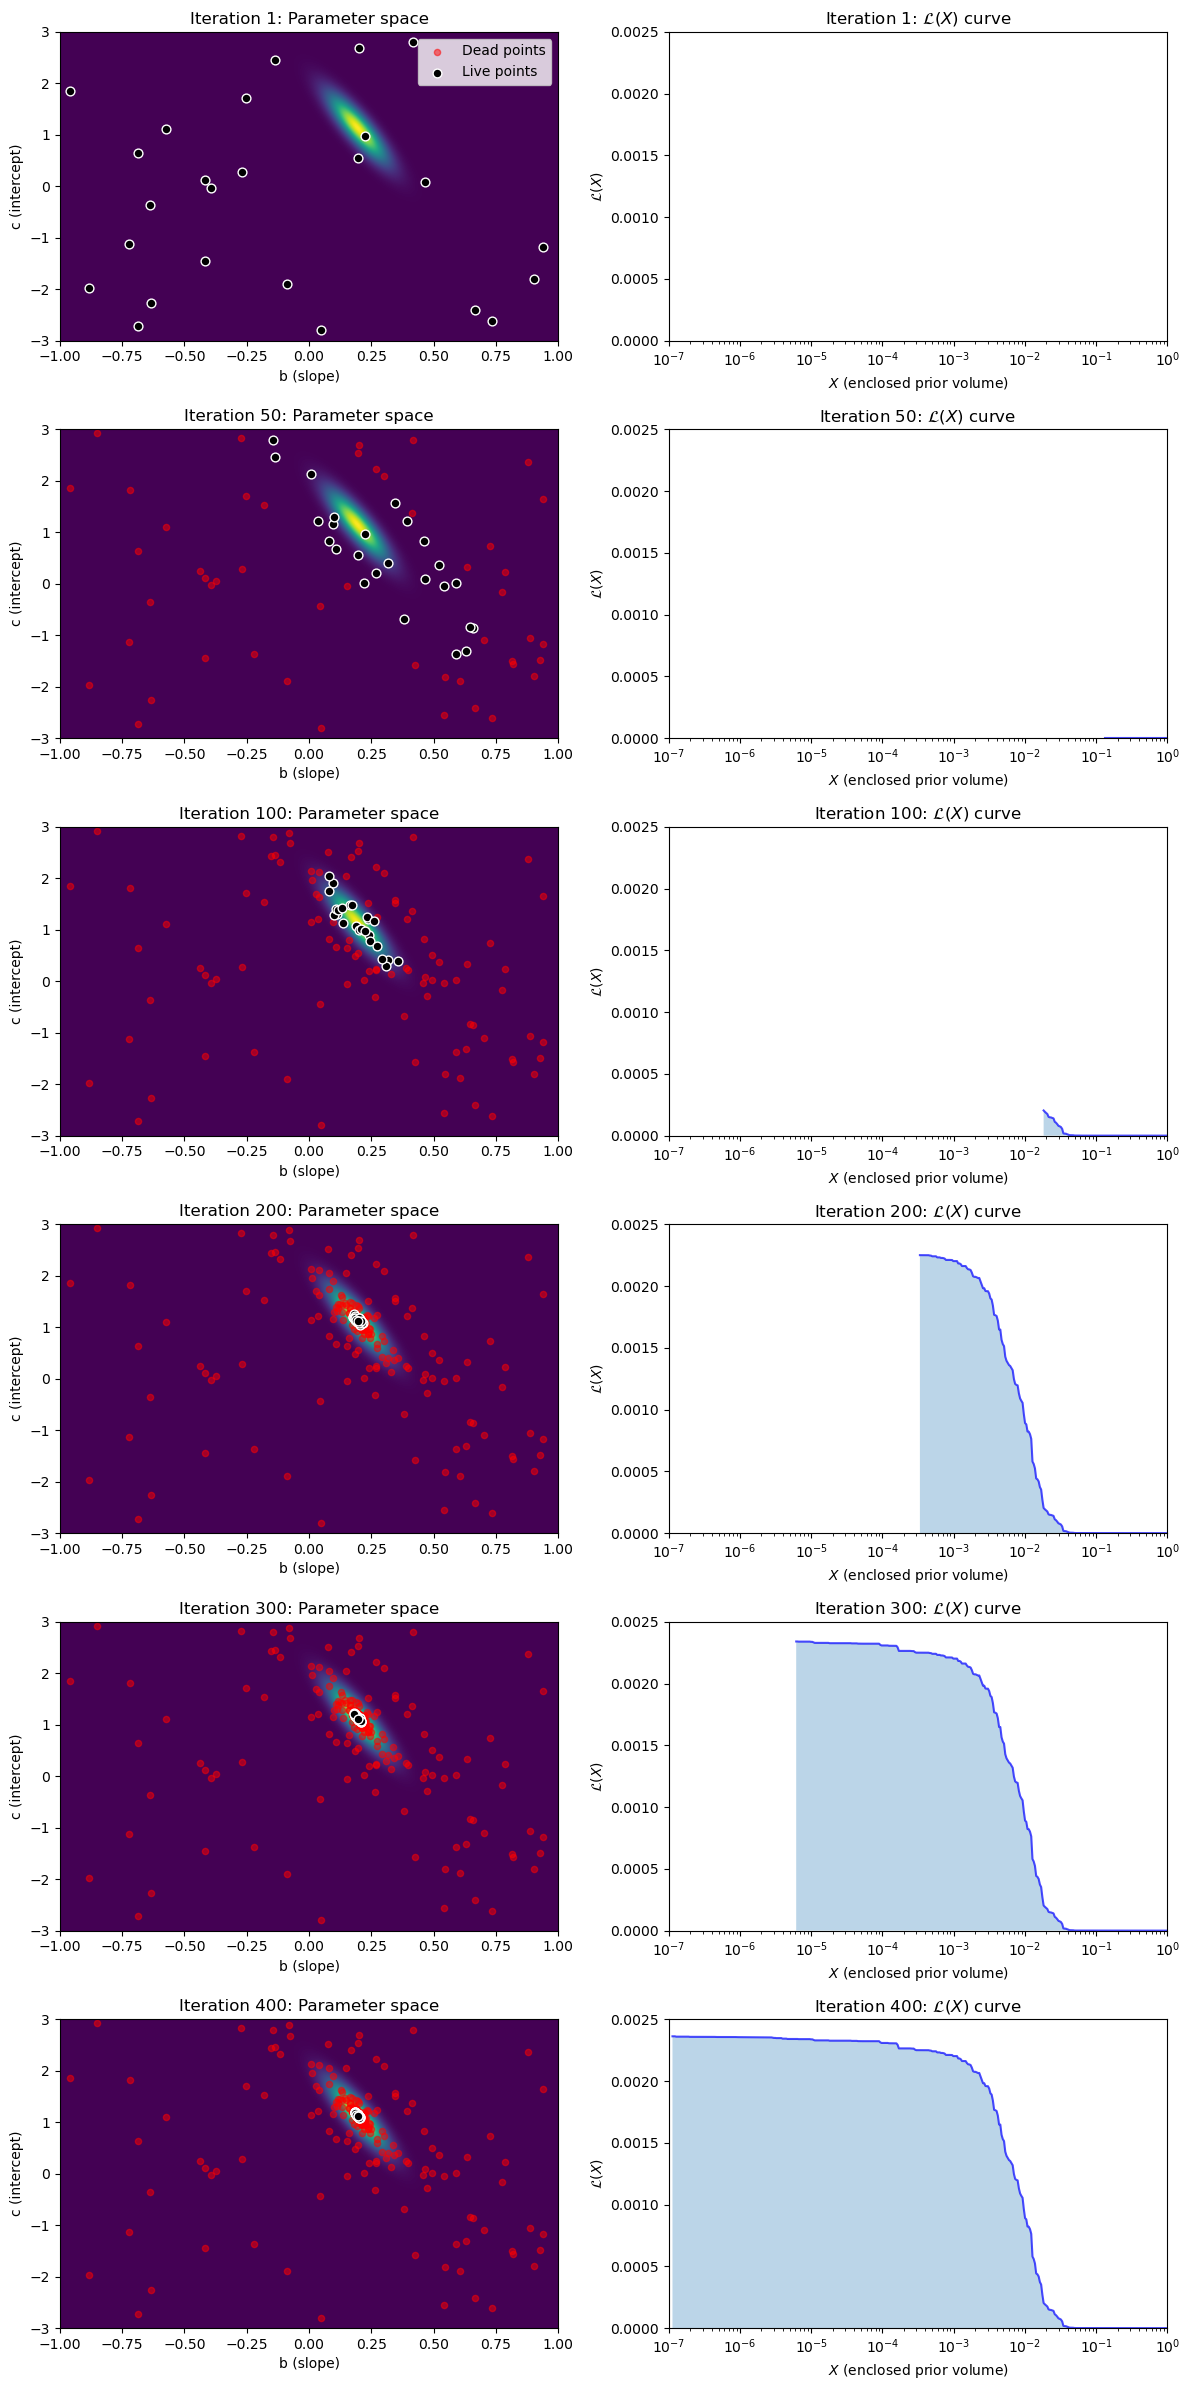

In [41]:
###################################################
# PLOT PROGRESS                                   #
###################################################
def plot_nested_sampling_progress(dead_points, dead_log_L, snapshots, iterations_to_show,
                                   L_surface_norm, B, C, b_min, b_max, c_min, c_max, K):
    """Plot nested sampling progress: parameter space and L(X) curve at each iteration."""
    
    X_all = np.exp(-np.arange(1, len(dead_log_L) + 1) / K)
    L_all = np.exp(dead_log_L)
    
    fig, axes = plt.subplots(len(iterations_to_show), 2, figsize=(12, 4 * len(iterations_to_show)))
    
    for idx, n_iter in enumerate(iterations_to_show):
        # Left: parameter space
        ax_left = axes[idx, 0]
        ax_left.imshow(L_surface_norm, extent=[b_min, b_max, c_min, c_max], 
                       origin='lower', cmap='viridis', aspect='auto')
        ax_left.scatter(dead_points[:n_iter, 0], dead_points[:n_iter, 1], 
                        color='red', s=20, alpha=0.5, label='Dead points')
        if n_iter in snapshots:
            ax_left.scatter(snapshots[n_iter][:, 0], snapshots[n_iter][:, 1], 
                            color='black', s=40, edgecolor='white', label='Live points')
        ax_left.set_xlabel('b (slope)')
        ax_left.set_ylabel('c (intercept)')
        ax_left.set_title(f'Iteration {n_iter}: Parameter space')
        if idx == 0:
            ax_left.legend(loc='upper right')
        
        # Right: L(X) curve
        ax_right = axes[idx, 1]
        ax_right.fill_between(X_all[:n_iter], L_all[:n_iter], alpha=0.3)
        ax_right.plot(X_all[:n_iter], L_all[:n_iter], 'b-', alpha=0.7)
        ax_right.set_xscale('log')
        ax_right.set_xlabel(r'$X$ (enclosed prior volume)')
        ax_right.set_ylabel(r'$\mathcal{L}(X)$')
        ax_right.set_xlim(1, 1e-7)
        ax_right.set_ylim(0, 0.0025)
        ax_right.invert_xaxis()
        ax_right.set_title(f'Iteration {n_iter}: $\\mathcal{{L}}(X)$ curve')
        
    plt.tight_layout()
    plt.show()

plot_nested_sampling_progress(
    dead_points, dead_log_L, snapshots, iterations_to_show,
    L_surface_norm, B, C, b_min, b_max, c_min, c_max, K
)

## Doing the same thing, but using Dynesty

Our toy implementation above works, but has a flaw - sampling from the prior becomes very inefficient once the likelihood contour encloses a tiny fraction of prior volume. Real nested sampling implementations solve this with smarter constrained sampling strategies—bounding ellipsoids, slice sampling, etc.

[Dynesty](https://dynesty.readthedocs.io/) is a popular Python implementation that handles all of this. Let's use it to compute the evidence for both models and compare.

Let's first define some helper functions. The first set are functions for the likelihood of each model - in our case just chi2, but you can give `dynesty` as complicated functions as you would like.

In [44]:
def log_likelihood_M0_dynesty(theta):
    """Log-likelihood for flat model"""
    c = theta
    model = c
    return -0.5 * np.sum(((y - model) / sigma)**2)


def log_likelihood_M1_dynesty(theta):
    """Log-likelihood for line model"""
    b, c = theta
    model = b * x + c
    return -0.5 * np.sum(((y - model) / sigma)**2)


`Dynesty` requires you to give the samples a prior transform function that you have defined. This function should map a unit hypercube (of dimensionality the same as the number of parameters you have) to your priors. In our case, our priors are simple. But the way `dynesty` is set up allows you to have as complex priors as you like as long as you can figure out the transform. 

In [46]:
def prior_transform_M0(u):
    c = u[0] * (c_max - c_min) + c_min
    return np.array([c])

def prior_transform_M1(u):
    """Transform unit cube to prior bounds."""
    b = u[0] * (b_max - b_min) + b_min  # uniform prior
    c = u[1] * (c_max - c_min) + c_min  # uniform prior
    return np.array([b, c])

Now we can set up the samplers using the `NestedSampler` class. It needs at least the likelihood function, the prior transform function, and the dimensions of the model. However, there are a tonne of parameters to fiddle with, such as the number of live points (default 500), if certain priors are periodic or reflective, multi-processing, etc.

In [48]:
# Model 0: Flat Line
sampler_M0 = dynesty.NestedSampler(
    log_likelihood_M0_dynesty,       # Likelihood
    prior_transform_M0,              # Prior Transform
    ndim=1,                          # Dimensions of your model
    nlive = 5000
)

# Model 1: Line with slope
sampler_M1 = dynesty.NestedSampler(
    log_likelihood_M1_dynesty,
    prior_transform_M1,
    ndim=2,
    nlive = 5000
)

In [49]:
##########################
# Run Sampler on Model 0 #
##########################

# run model
sampler_M0.run_nested()

# results object
results_M0 = sampler_M0.results

print(f"log(Z) = {results_M0.logz[-1]:.2f} +/- {results_M0.logzerr[-1]:.2f}")
print(f"Z = {np.exp(results_M0.logz[-1]):.6e}")

8435it [00:02, 3945.03it/s, +5000 | bound: 0 | nc: 1 | ncall: 31982 | eff(%): 49.792 | loglstar:   -inf < -9.178 <    inf | logz: -11.555 +/-    nan | dlogz:  0.000 >  5.009]

log(Z) = -11.56 +/- 0.08
Z = 9.587852e-06


In [50]:
##########################
# Run Sampler on Model 1 #
##########################

sampler_M1.run_nested()
results_M1 = sampler_M1.results

print(f"log(Z) = {results_M1.logz[-1]:.2f} +/- {results_M1.logzerr[-1]:.2f}")
print(f"Z = {np.exp(results_M1.logz[-1]):.6e}")

16812it [00:06, 2772.81it/s, +5000 | bound: 0 | nc: 1 | ncall: 152529 | eff(%): 14.785 | loglstar:   -inf < -6.038 <    inf | logz: -10.686 +/-  0.025 | dlogz:  0.001 >  5.009]

log(Z) = -10.69 +/- 0.15
Z = 2.285940e-05


You can see that these models were very fast! You may note that the evidence values are different to what we calculated above, but that was because the manual implemenation I wrote sucks. This is more accurate. However, if we calculate the bayes factor we get a similar result (recall our manual version gave us $B_{10} = 2.25$)

In [52]:
log_BF = results_M1.logz[-1] - results_M0.logz[-1]
print(f"log(Bayes factor) = {log_BF:.2f}")
print(f"Bayes factor (M1/M0) = {np.exp(log_BF):.1f}")

log(Bayes factor) = 0.87
Bayes factor (M1/M0) = 2.4


## Parameter Posteriors with Nested Sampling

A cool side effect of nested sampling is that you get parameter posteriors "for free". From the list of dead points, we have the prior volume $\Delta X_i$ of each point, and the corresponding likelihood of each point $\mathcal{L}_i$. Recall Bayes theorem is Posterior = Likelihood $\times$ Prior. As with an MCMC approach, we don't need to care about calculating the evidence in this case. 

In `dynesty`, we can recover the posteriors by using its built in cornerplot function:

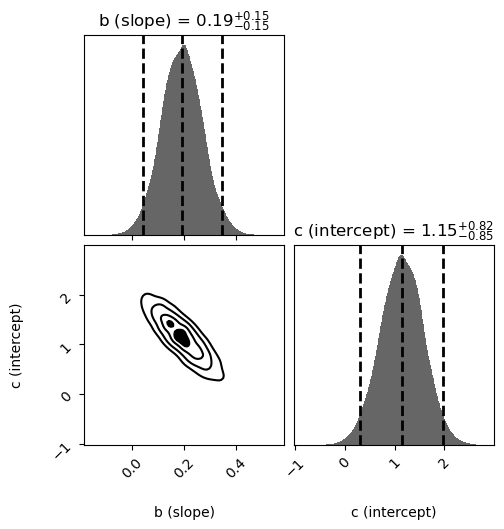

In [54]:
fig, axes = dyplot.cornerplot(
    results_M1, 
    labels=['b (slope)', 'c (intercept)'],
    show_titles=True
)

# By default, the credible region shown is 95%, not 68%. 

Another useful built in function is the `traceplot`. The bellow plot is fairly boring, but for more complicated likelihood spaces, this can be a much more interesting plot. See this example in the `dynesty` docs: https://dynesty.readthedocs.io/en/v3.0.0/examples.html#exponential-wave

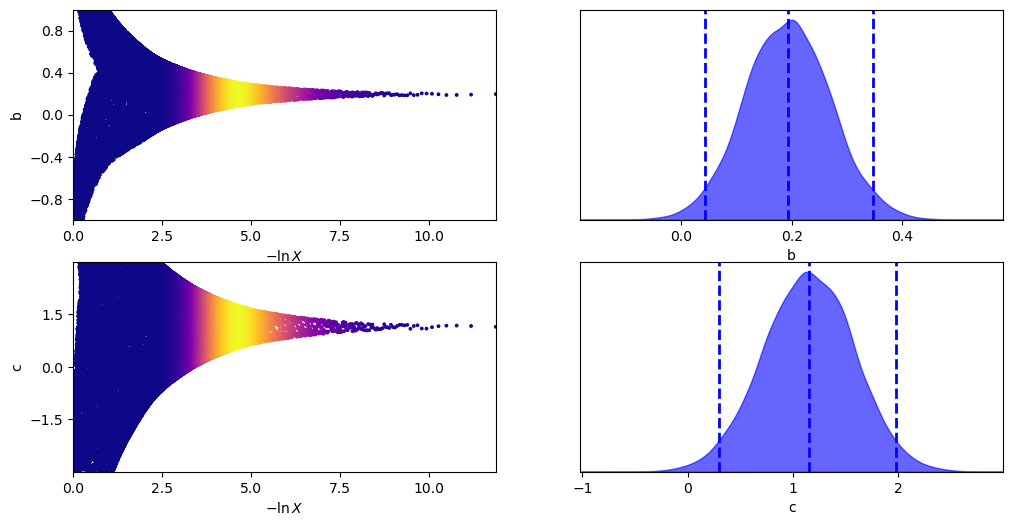

In [56]:
fig, axes = dyplot.traceplot(results_M1, labels=['b', 'c'])

Additionally, `dynesty` has a built in diagnostic plot, called `runplot`:

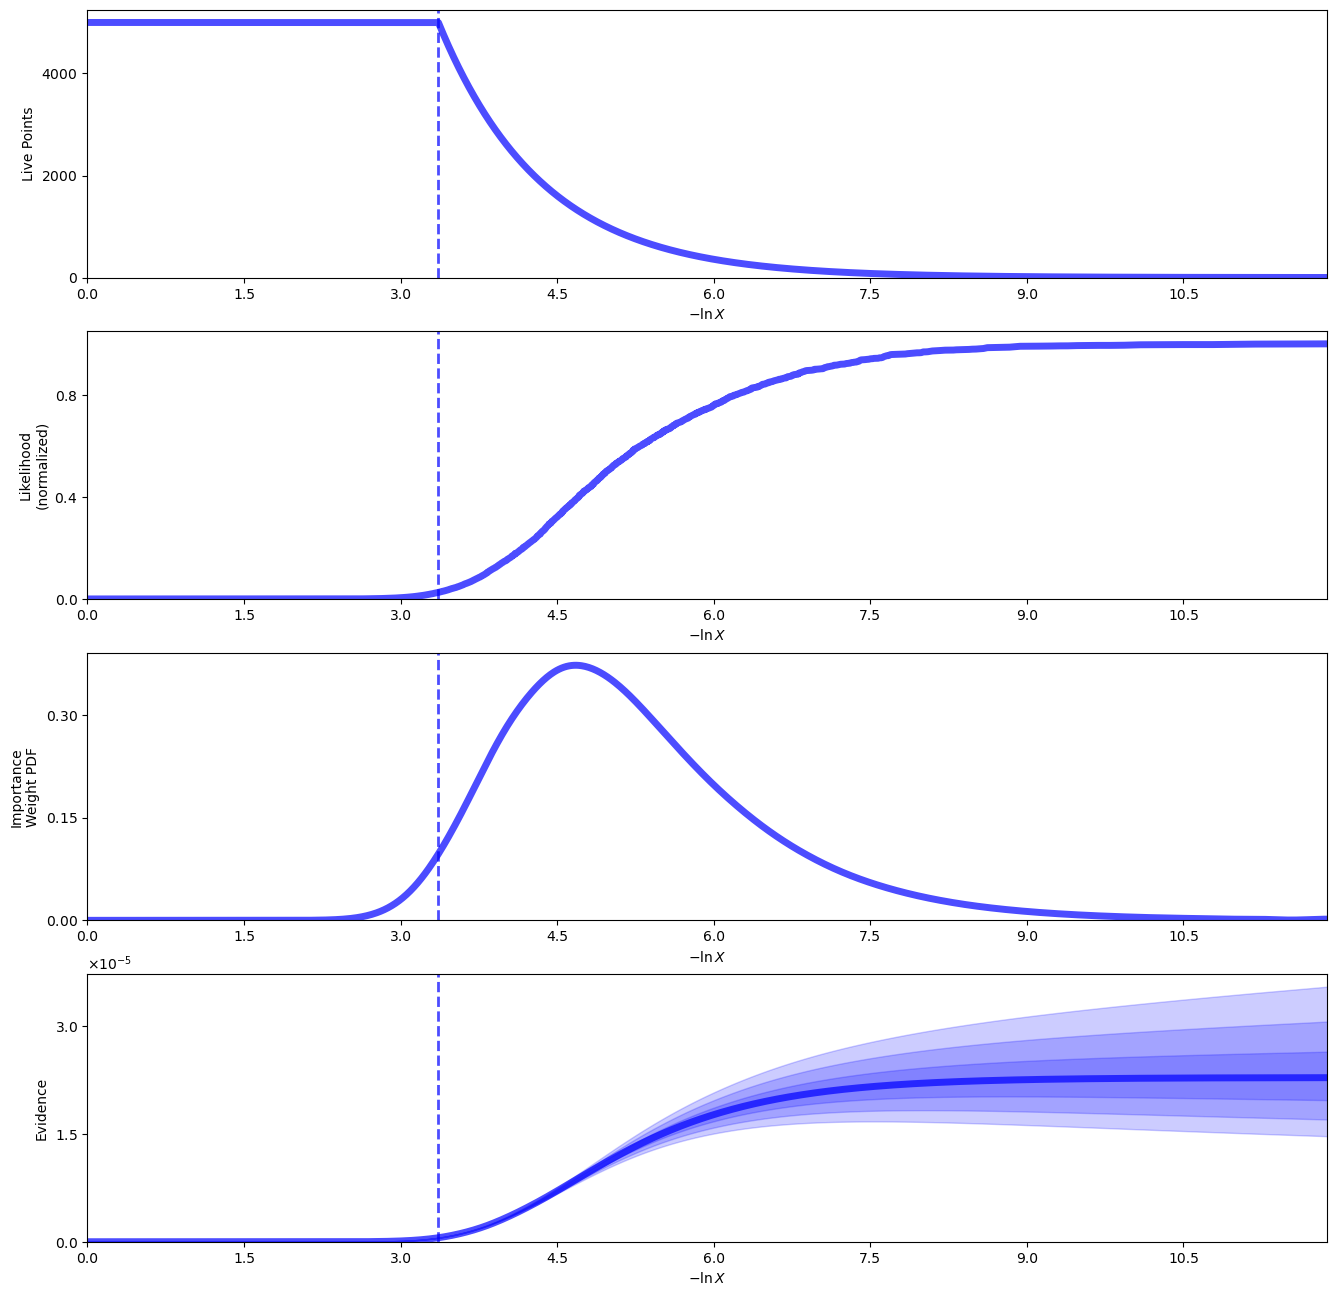

In [58]:
fig, axes = dyplot.runplot(results_M1)

## Nested Sampling vs MCMC

Nested Sampling gives you posteriors and evidence, while MCMC only gives you posteriors. However, Nested Sampling is not a silver bullet, there are some downsides with it. Below is a list of Pros and Cons of each method

#### Nested Sampling Pros:
- Computes evidence, allows model comparison
- Handles multimodel posteriors well, by construction it explores the full prior volume
- Posterior samples for "free"

#### Nested Sampling Cons:
- Computationally expensive in high dimensions (more space to explore)
- Each sample is more expensive compared to MCMC (but often need much less samples)
- Evidence **strongly** depends on prior choice

#### MCMC Pros
- Computationally cheaper for high dimensions
- Works with improper priors

#### MCMC Cons:
- Does not compute evidence (no model comparison)
- Can struggle with multimodal posteriors


----------
## Importance of Prior choice in Nested Sampling

When doing nested sampling, you are trying to compute the evidence:

$$ \mathcal{Z} = \int \mathcal{L}(\theta)\pi(\theta) \;d\theta $$

If you were to make your prior ($\pi(\theta)$) 10x wider, you are integrating 10x more volume where the likelihood is essentially zero - **this will change the value of the evidence**. This also means that the Bayes factor will change, meaning the preferred model could change.

This may seem like a problem, but philisophically it is an honest reflection of your knowledge. Two scientists with different priors may get different results from the same data, but what this is saying is that your data is not informative enough to be decisive. It is also a reflection of Occams razor - a model with a wider prior could be fit more data, while a narrow prior can fit less data. So the evidence naturally penalises more flexible models which is aligned with Occams razor. 

In practice, to ensure that you results are robust, you can try a few different priors to see how that impacts the result. 

## Extra: Swapping Priors

There is actually a way to "swap" priors so that you can calculate the evidence under different prior assumptions. This only works if the prior that the nested sampling was run under was wider than any new prior, if you want to test a prior that covers more space than what was originally run, you will need to rerun the nested sampling. To do so, you need to solve:

$$ \mathcal{Z}' = Z \langle \frac{\pi'(\theta)}{\pi(\theta)} \rangle_{\text{posterior}} \approx \sum_i w_i \frac{\pi'(\theta)}{\pi(\theta)} $$

Recall back to our $M1$ model. We had two parameters, an intercept $c$ and a slope $b$. Previously, we $c$ a uniform prior from [-3, 3]. Assume that for some reason, we belive that the intercept should be close to zero (which it actually is). To represent this prior knowledge, we will change the prior from a uniform prior to be Gaussian centred on 0, with a variance of 0.5:

In [60]:
######################
# Extract M1 Results #
######################

samples_c = results_M1.samples[:,1]
weights = results_M1.importance_weights()  # This is our w_i
log_Z_uniform = results_M1.logz[-1]        # Evidence for our uniform prior

####################
# Define New Prior #
####################

c_min, c_max = -3, 3
sigma_c = 0.5

#############################
# Calculate Prior Densities #
#############################

pi_old = np.ones_like(samples_c) / (c_max - c_min)  # uniform density
pi_new = np.exp(-0.5 * (samples_c/sigma_c)**2) / (sigma_c * np.sqrt(2*np.pi))  # Gaussian density

# prior ratio at each sample
ratio = pi_new / pi_old

# take weighted average over the posterior
expectation_sum = np.sum(weights * ratio)

##########################
# Calculate New Evidence #
##########################

Z_old = np.exp(log_Z_uniform)
Z_new = Z_old * expectation_sum

#################################
# Reweighted Posterior Weights  #
#################################

posterior_weights_new = weights * ratio
posterior_weights_new = posterior_weights_new / np.sum(posterior_weights_new)

print(f"Original Z: {Z_old:.2e}")
print(f"Reweighted Z: {Z_new:.2e}")

Original Z: 2.29e-05
Reweighted Z: 1.83e-05


In [61]:
#############################################
# Compute Marginal Likelihood for c in M1   #
# (integrate over b)                        #
#############################################

b_min, b_max = -1, 1
b_range = np.linspace(b_min, b_max, 200)
c_range = np.linspace(c_min, c_max, 200)
db = b_range[1] - b_range[0]

L_M1_marginal_c = []
for c in c_range:
    L_integrated = 0
    for b in b_range:
        chi2 = np.sum(((y - M1(x, b, c)) / sigma)**2)
        L_integrated += np.exp(-0.5 * chi2) * db
    # Average over b (uniform prior on b)
    L_M1_marginal_c.append(L_integrated / (b_max - b_min))

L_M1_marginal_c = np.array(L_M1_marginal_c)

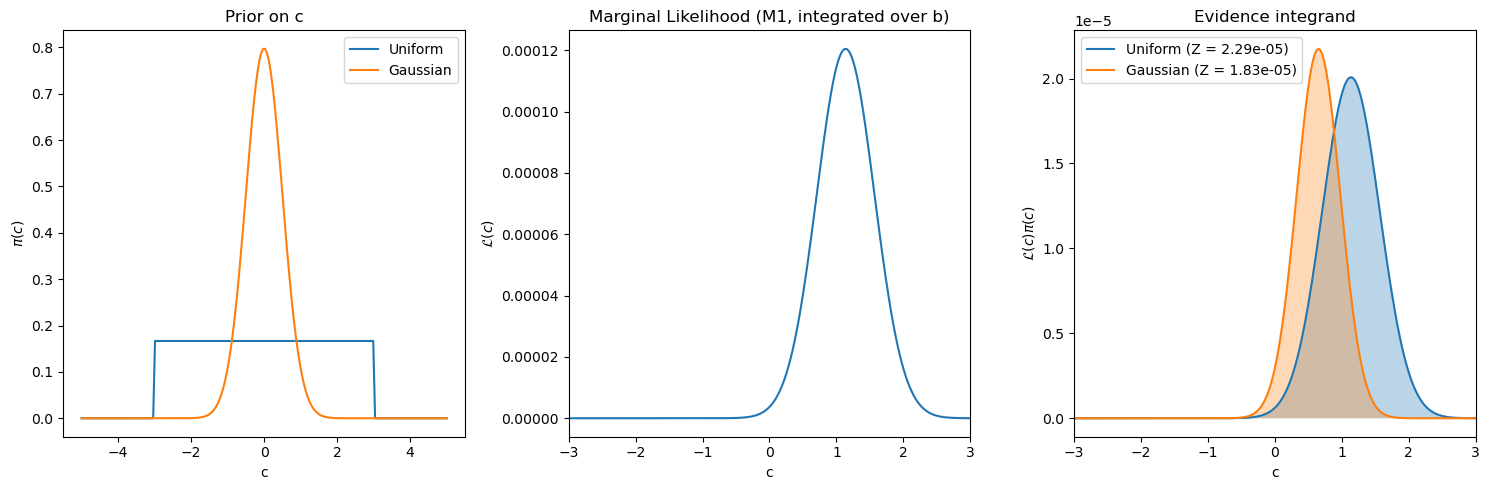

In [62]:
plt.figure(figsize=(15,5))

c_plot = np.linspace(-5, 5, 200)
prior_uniform = np.where((c_plot >= c_min) & (c_plot <= c_max), 1/(c_max - c_min), 0)
prior_gaussian = np.exp(-0.5 * (c_plot / sigma_c)**2) / (sigma_c * np.sqrt(2 * np.pi))

plt.subplot(1,3,1)
plt.plot(c_plot, prior_uniform, label='Uniform')
plt.plot(c_plot, prior_gaussian, label='Gaussian')
plt.xlabel('c')
plt.ylabel(r'$\pi(c)$')
plt.title('Prior on c')
plt.legend()

plt.subplot(1,3,2)
plt.plot(c_range, L_M1_marginal_c)
plt.xlabel('c')
plt.ylabel(r'$\mathcal{L}(c)$')
plt.title('Marginal Likelihood (M1, integrated over b)')
plt.xlim(-3, 3)

plt.subplot(1,3,3)
integrand_uniform = L_M1_marginal_c / (c_max - c_min)
integrand_gaussian = L_M1_marginal_c * np.exp(-0.5 * (c_range / sigma_c)**2) / (sigma_c * np.sqrt(2 * np.pi))
plt.fill_between(c_range, integrand_uniform, alpha=0.3)
plt.fill_between(c_range, integrand_gaussian, alpha=0.3)
plt.plot(c_range, integrand_uniform, label=f'Uniform (Z = {Z_old:.2e})')
plt.plot(c_range, integrand_gaussian, label=f'Gaussian (Z = {Z_new:.2e})')
plt.xlabel('c')
plt.ylabel(r'$\mathcal{L}(c)\pi(c)$')
plt.title('Evidence integrand')
plt.legend()
plt.xlim(-3, 3)

plt.tight_layout()
plt.show()

In [63]:
# Sort samples and accumulate weights
sort_idx = np.argsort(samples_c)
samples_sorted = samples_c[sort_idx]
weights_sorted = posterior_weights_new[sort_idx]
cumulative = np.cumsum(weights_sorted)

# Find 2.5% and 97.5% quantiles
lower_idx = np.searchsorted(cumulative, 0.025)
upper_idx = np.searchsorted(cumulative, 0.975)
median_idx = np.searchsorted(cumulative, 0.5)

c_lower = samples_sorted[lower_idx]
c_upper = samples_sorted[upper_idx]
c_median = samples_sorted[median_idx]

print(f"New posterior median: {c_median:.3f}")
print(f"95% credible interval: [{c_lower:.3f}, {c_upper:.3f}]")

New posterior median: 0.663
95% credible interval: [0.007, 1.305]


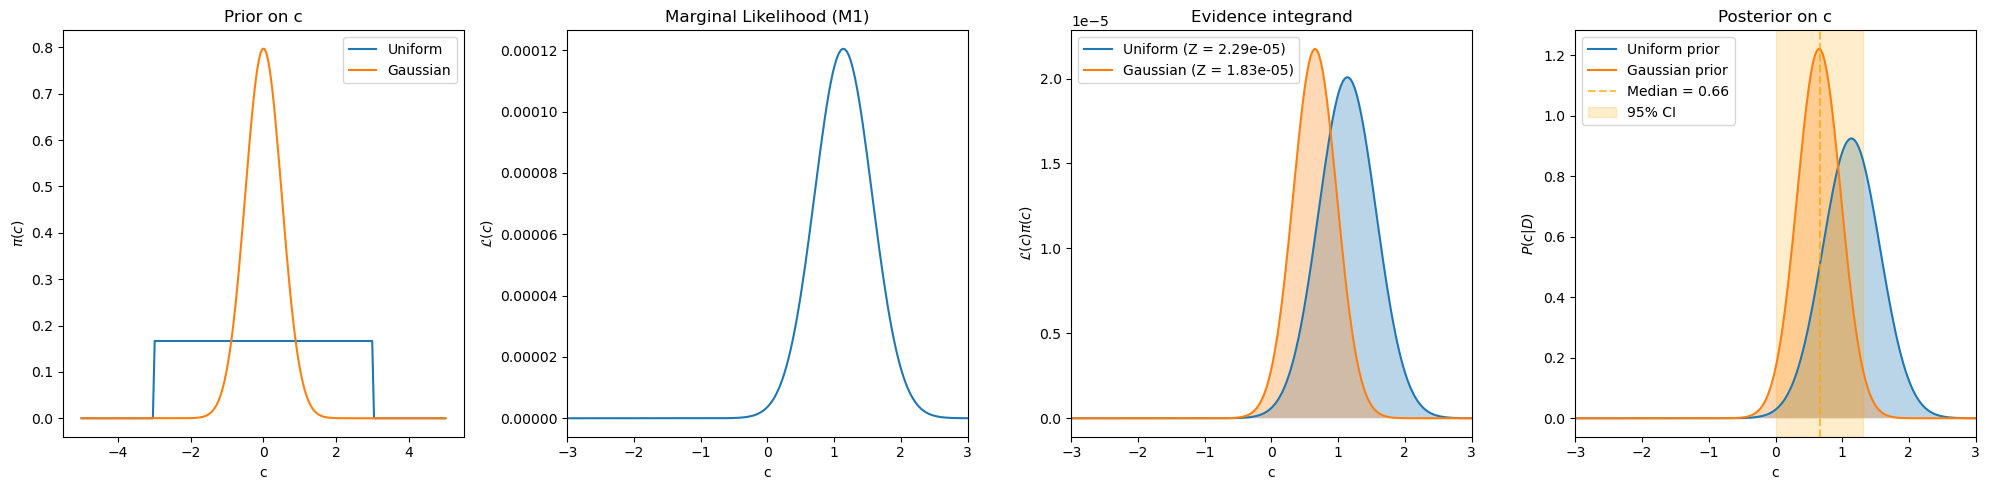

In [64]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.plot(c_plot, prior_uniform, label='Uniform')
plt.plot(c_plot, prior_gaussian, label='Gaussian')
plt.xlabel('c')
plt.ylabel(r'$\pi(c)$')
plt.title('Prior on c')
plt.legend()

plt.subplot(1,4,2)
plt.plot(c_range, L_M1_marginal_c)
plt.xlabel('c')
plt.ylabel(r'$\mathcal{L}(c)$')
plt.title('Marginal Likelihood (M1)')
plt.xlim(-3, 3)

plt.subplot(1,4,3)
plt.fill_between(c_range, integrand_uniform, alpha=0.3)
plt.fill_between(c_range, integrand_gaussian, alpha=0.3)
plt.plot(c_range, integrand_uniform, label=f'Uniform (Z = {Z_old:.2e})')
plt.plot(c_range, integrand_gaussian, label=f'Gaussian (Z = {Z_new:.2e})')
plt.xlabel('c')
plt.ylabel(r'$\mathcal{L}(c)\pi(c)$')
plt.title('Evidence integrand')
plt.legend()
plt.xlim(-3, 3)

plt.subplot(1,4,4)
posterior_uniform = integrand_uniform / np.trapz(integrand_uniform, c_range)
posterior_gaussian = integrand_gaussian / np.trapz(integrand_gaussian, c_range)
plt.fill_between(c_range, posterior_uniform, alpha=0.3)
plt.fill_between(c_range, posterior_gaussian, alpha=0.3)
plt.plot(c_range, posterior_uniform, label='Uniform prior')
plt.plot(c_range, posterior_gaussian, label='Gaussian prior')
plt.axvline(c_median, color='orange', ls='--', alpha=0.7, label=f'Median = {c_median:.2f}')
plt.axvspan(c_lower, c_upper, alpha=0.2, color='orange', label=f'95% CI')
plt.xlabel('c')
plt.ylabel(r'$P(c|D)$')
plt.title('Posterior on c')
plt.legend()
plt.xlim(-3, 3)

plt.tight_layout()
plt.show()

In [65]:
#####################################
# Compare Reweighted M1 to M0       #
#####################################

# M0 evidence (from dynesty)
Z_M0 = np.exp(results_M0.logz[-1])

# M1 with uniform prior on c
Z_M1_uniform = Z_old

# M1 with Gaussian prior on c
Z_M1_gaussian = Z_new

print("Evidence values:")
print(f"  M0:                Z = {Z_M0:.2e}")
print(f"  M1 (uniform c):    Z = {Z_M1_uniform:.2e}")
print(f"  M1 (Gaussian c):   Z = {Z_M1_gaussian:.2e}")

print("\nBayes factors (relative to M0):")
BF_M1_uniform = Z_M1_uniform / Z_M0
BF_M1_gaussian = Z_M1_gaussian / Z_M0
print(f"  M1 (uniform c)  / M0:  B = {BF_M1_uniform:.2f}")
print(f"  M1 (Gaussian c) / M0:  B = {BF_M1_gaussian:.2f}")

print("\nModel probabilities (assuming equal prior odds):")
Z_total_uniform = Z_M0 + Z_M1_uniform
Z_total_gaussian = Z_M0 + Z_M1_gaussian

print("  With uniform prior on c:")
print(f"    P(M0|D) = {Z_M0/Z_total_uniform:.3f}")
print(f"    P(M1|D) = {Z_M1_uniform/Z_total_uniform:.3f}")

print("  With Gaussian prior on c:")
print(f"    P(M0|D) = {Z_M0/Z_total_gaussian:.3f}")
print(f"    P(M1|D) = {Z_M1_gaussian/Z_total_gaussian:.3f}")

Evidence values:
  M0:                Z = 9.59e-06
  M1 (uniform c):    Z = 2.29e-05
  M1 (Gaussian c):   Z = 1.83e-05

Bayes factors (relative to M0):
  M1 (uniform c)  / M0:  B = 2.38
  M1 (Gaussian c) / M0:  B = 1.91

Model probabilities (assuming equal prior odds):
  With uniform prior on c:
    P(M0|D) = 0.295
    P(M1|D) = 0.705
  With Gaussian prior on c:
    P(M0|D) = 0.344
    P(M1|D) = 0.656


In this case, the model is less favoured with the Gaussian prior. This is because the data (although very noisy) favours a higher intercept. 